In [1]:
import torch
import torch.nn as nn
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class ResBlock(nn.Module):
  def __init__(self, ch):
    super().__init__()
    self.block = nn.Sequential(
      nn.Conv2d(ch, ch, 3, padding=1, bias=False),
      nn.BatchNorm2d(ch),
      nn.PReLU(),
      nn.Conv2d(ch, ch, 3, padding=1, bias=False),
      nn.BatchNorm2d(ch),
    )

  def forward(self, x):
    res = x
    out = self.block(x)
    out += res
    return out

class UpsampleBlock(nn.Module):
  def __init__(self, in_ch, out_ch, scale):
    super().__init__()
    self.block = nn.Sequential(
      nn.Conv2d(in_ch, out_ch, 3, padding=1),
      nn.PixelShuffle(scale),
      nn.PReLU(),
    )

  def forward(self, x):
    return self.block(x)

In [4]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 64, 9, padding=4),
      nn.PReLU(),
    )
    self.resblocks = nn.Sequential(*[ResBlock(64) for _ in range(16)])
    self.conv2 = nn.Sequential(
      nn.Conv2d(64, 64, 3, padding=1, bias=False),
      nn.BatchNorm2d(64),
    )
    self.upsample = nn.Sequential(*[UpsampleBlock(64, 256, 2) for _ in range(2)])
    self.conv3 = nn.Conv2d(64, 3, 9, padding=4)

  def forward(self, x):
    res = self.conv1(x)
    out = self.resblocks(res)
    out = self.conv2(out)
    out += res
    out = self.upsample(out)
    out = self.conv3(out)
    return out

In [5]:
gen = Generator()
gen.to(device)
weights = torch.load("data/SRResNet_x4-ImageNet-6dd5216c.pth.tar", map_location=device)
state_dict = {k: v for k, v in zip(gen.state_dict().keys(), weights["state_dict"].values())}
gen.load_state_dict(state_dict)

<All keys matched successfully>

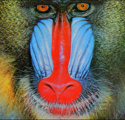

In [6]:
img = Image.open("data/baboon.png")
img

In [7]:
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0).to(device)

In [8]:
with torch.no_grad():
  out = gen(tensor).squeeze(0)

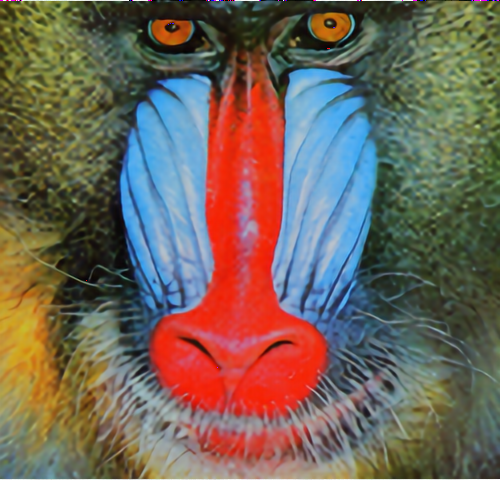

In [9]:
upscaled = transforms.ToPILImage()(out)
upscaled

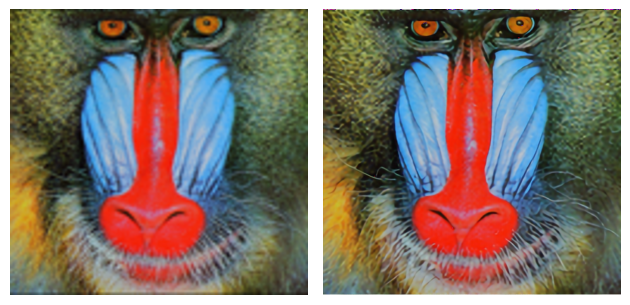

In [10]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(img.resize(upscaled.size))
axes[0].axis('off')

axes[1].imshow(upscaled)
axes[1].axis('off')

plt.tight_layout()
plt.show()